## Implementation with pre trained weights from Tacotron 2

#### Source: https://pytorch.org/audio/stable/tutorials/tacotron2_pipeline_tutorial.html

![tacotron_schema](../img/tacotron_schema.png)

In [3]:
import torch 
import torchaudio 
import IPython
import matplotlib.pyplot as plt

torch.random.manual_seed(42)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


## Character based-encoding

In [2]:
characters = "_-!'(),.:;? abcdefghijklmnopqrstuvwxyz"
look_up = {s: i for i, s in enumerate(characters)}
symbols = set(characters)

def text2sequence(text):
    text = text.lower()
    return [look_up[s] for s in text if s in symbols]

text = "Ola mundo!"
processor = text2sequence(text)
processed = torch.tensor(processor)
lengths = len(processed)
print(processed)
print(lengths)

tensor([26, 23, 12, 11, 24, 32, 25, 15, 26,  2])
10


In [3]:
print([characters[i] for i in processed[:lengths]])

['o', 'l', 'a', ' ', 'm', 'u', 'n', 'd', 'o', '!']


## Phoneme-based encoding

In [25]:
bundle = torchaudio.pipelines.TACOTRON2_WAVERNN_PHONE_LJSPEECH

processor = bundle.get_text_processor()
print("----------------")
print("Character", characters)
print(type(processor.tokens))
print("Phonemes", processor.tokens)
print(len(characters))
print(len(processor.tokens))
print("----------------")

text = "Meu nome é Eduardo"
with torch.inference_mode():
    processed, lengths = processor(text)

print(processed)

----------------
Character _-!'(),.:;? abcdefghijklmnopqrstuvwxyz
<class 'tuple'>
Phonemes ('_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'AA', 'AA0', 'AA1', 'AA2', 'AE', 'AE0', 'AE1', 'AE2', 'AH', 'AH0', 'AH1', 'AH2', 'AO', 'AO0', 'AO1', 'AO2', 'AW', 'AW0', 'AW1', 'AW2', 'AY', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH', 'EH0', 'EH1', 'EH2', 'ER', 'ER0', 'ER1', 'ER2', 'EY', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH', 'IH0', 'IH1', 'IH2', 'IY', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OW0', 'OW1', 'OW2', 'OY', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH')
38
96
----------------
tensor([[66, 93, 87, 11, 67, 69, 66, 11, 11, 40, 38, 92, 12, 78, 38, 69]])


/home/weber/projects/rememberUrVoice/venv/lib/python3.10/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [26]:
print([processor.tokens[i] for i in processed[0, : lengths[0]]])

['M', 'Y', 'UW', ' ', 'N', 'OW', 'M', ' ', ' ', 'EH', 'D', 'W', 'AA', 'R', 'D', 'OW']


## Spectogram Generation

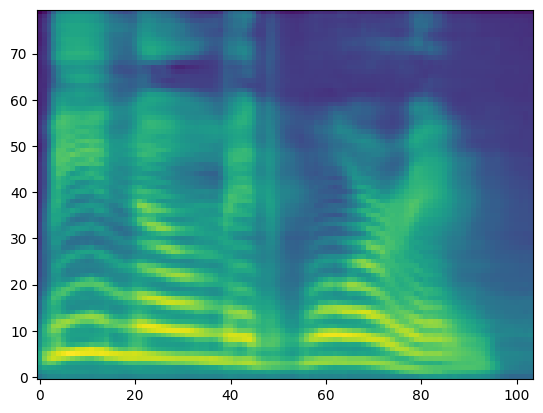

In [27]:
tacotron2 = bundle.get_tacotron2().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, _, _ = tacotron2.infer(processed, lengths)

_ = plt.imshow(spec[0].cpu().detach(), origin="lower", aspect="auto")

## Waveform Generation

#### WaveRNN Vocoder

In [28]:
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
    waveforms, lengths = vocoder(spec, spec_lengths)

In [1]:
import IPython.display


def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin='lower', aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

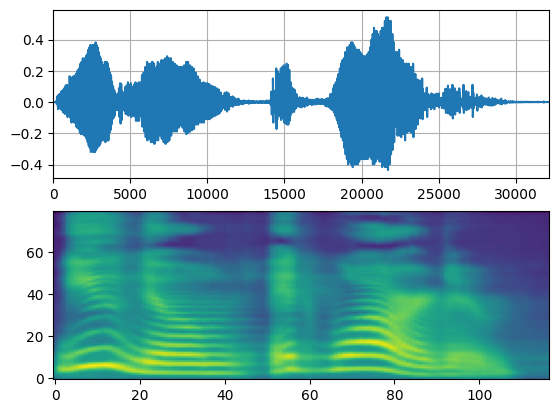

In [30]:
plot(waveforms, spec, vocoder.sample_rate)

#### Griffin-Lim Vocoder

In [10]:
bundle = torchaudio.pipelines.TACOTRON2_GRIFFINLIM_PHONE_LJSPEECH

processor = bundle.get_text_processor()
tacotron2 = bundle.get_tacotron2().to(device)
vocoder = bundle.get_vocoder().to(device)

with torch.inference_mode():
    processed, lengths = processor(text)
    processed = processed.to(device)
    lengths = lengths.to(device)
    spec, spec_lengths, _ = tacotron2.infer(processed, lengths)
waveforms, lengths = vocoder(spec, spec_lengths)

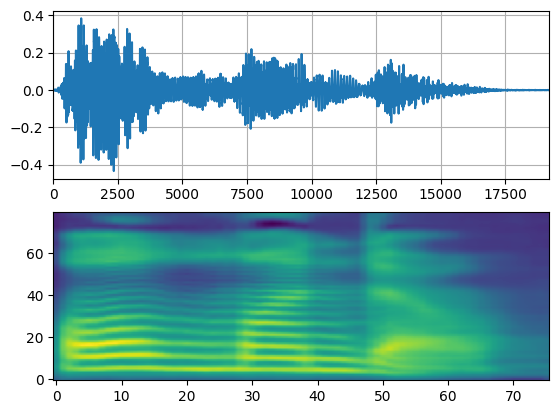

In [11]:
plot(waveforms, spec, vocoder.sample_rate)

In [12]:
ptbr_phonemes = (' ', '!', "'", '(', ')', ',', '.', ':', ';', '?', '-', '_', 'a', 'AA', 'AH', 'AO', 'AX', 'B', 'b', 'BV', 'c', 'CH', 'd', 'D', 'e', 'EH', 'EHN', 'EY', 'f', 'F', 'g', 'G', 'GN', 'h', 'HH', 'i', 'IY', 'j', 'JH', 'k', 'K', 'l', 'L', 
'm', 'M', 'n', 'N', 'NG', 'o', 'ON', 'OW', 'p', 'P', 'q', 'r', 'R', 'RR', 's', 'S', 'SH', 't', 'T', 'u', 'UW', 'UN', 'v', 'w', 'W', 'x', 'y', 'Y', 'YW', 'z', 'Z', 'ZH'
)

In [13]:
print("Phonemes", processor.tokens)

Phonemes ('_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'AA', 'AA0', 'AA1', 'AA2', 'AE', 'AE0', 'AE1', 'AE2', 'AH', 'AH0', 'AH1', 'AH2', 'AO', 'AO0', 'AO1', 'AO2', 'AW', 'AW0', 'AW1', 'AW2', 'AY', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH', 'EH0', 'EH1', 'EH2', 'ER', 'ER0', 'ER1', 'ER2', 'EY', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH', 'IH0', 'IH1', 'IH2', 'IY', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OW0', 'OW1', 'OW2', 'OY', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH')


### tokenizer ptbr v1

In [14]:
class PTBRTokenizer:
    def __init__(self, phonemes):
        self.phonemes = phonemes
        self.token2id = {token: idx for idx, token in enumerate(phonemes)}
    
    def __call__(self, text):
        phoneme_sequence = self.text2phonemes(text)
        ids = [self.token2id[p] for p in phoneme_sequence]
        return torch.tensor([ids]), torch.tensor([len(ids)], dtype=torch.int32)
    
    def text2phonemes(self, text):
        text = text.lower()
        phoneme_sequence = []
        i = 0
        while i < len(text):
            char = text[i]
            if char == 'a':
                phoneme_sequence.append('AA')
            elif char == 'e':
                phoneme_sequence.append('EH')
            elif char == 'i':
                phoneme_sequence.append('IY')
            elif char == 'o':
                phoneme_sequence.append('OW')
            elif char == 'u':
                phoneme_sequence.append('UW')
            elif char == 'r' and (i + 1 < len(text) and text[i + 1] == 'r'):
                phoneme_sequence.append('RR')
                i += 1  
            elif char == 'c' and (i + 1 < len(text) and text[i + 1] == 'h'):
                phoneme_sequence.append('CH')
                i += 1  
            elif char == 'g' and (i + 1 < len(text) and text[i + 1] == 'n'):
                phoneme_sequence.append('GN')
                i += 1  
            elif char == 'á':
                phoneme_sequence.append('AA')  
            elif char == 'é':
                phoneme_sequence.append('EH')  
            elif char == 'í':
                phoneme_sequence.append('IY')  
            elif char == 'ó':
                phoneme_sequence.append('OW')  
            elif char == 'ú':
                phoneme_sequence.append('UW')  
            elif char == 'â':
                phoneme_sequence.append('AA')  
            elif char == 'ê':
                phoneme_sequence.append('EH')  
            elif char == 'ô':
                phoneme_sequence.append('OW')  
            elif char == 'ã':
                phoneme_sequence.append('AA')  
            elif char == 'õ':
                phoneme_sequence.append('OW')  
            elif char in self.token2id:
                phoneme_sequence.append(char.upper())
            else:
                phoneme_sequence.append('_') 
            i += 1
        return phoneme_sequence

In [31]:
ptbr_processor = PTBRTokenizer(ptbr_phonemes)

text = "My name is Eduardo"
with torch.inference_mode():
    processed, lengths = processor(text)
    new_processed, new_lengths = ptbr_processor(text)
    new_processed = new_processed.to(device)
    new_lengths = new_lengths.to(device)

print("Processed (original):", processed)
print("Processed (PT-BR)", new_processed)
print("Lengths (original)", lengths)
print("Lengths (PT-BR)", new_lengths)

Processed (original): tensor([[66, 32, 11, 67, 48, 66, 11, 55, 94, 11, 40, 38, 92, 12, 78, 38, 69]])
Processed (PT-BR) tensor([[44, 70,  0, 46, 13, 44, 25,  0, 36, 58,  0, 25, 23, 63, 13, 55, 23, 50]],
       device='cuda:0')
Lengths (original) tensor([17], dtype=torch.int32)
Lengths (PT-BR) tensor([18], device='cuda:0', dtype=torch.int32)


In [32]:
print(ptbr_phonemes)
print(processor.tokens)

(' ', '!', "'", '(', ')', ',', '.', ':', ';', '?', '-', '_', 'a', 'AA', 'AH', 'AO', 'AX', 'B', 'b', 'BV', 'c', 'CH', 'd', 'D', 'e', 'EH', 'EHN', 'EY', 'f', 'F', 'g', 'G', 'GN', 'h', 'HH', 'i', 'IY', 'j', 'JH', 'k', 'K', 'l', 'L', 'm', 'M', 'n', 'N', 'NG', 'o', 'ON', 'OW', 'p', 'P', 'q', 'r', 'R', 'RR', 's', 'S', 'SH', 't', 'T', 'u', 'UW', 'UN', 'v', 'w', 'W', 'x', 'y', 'Y', 'YW', 'z', 'Z', 'ZH')
('_', '-', '!', "'", '(', ')', ',', '.', ':', ';', '?', ' ', 'AA', 'AA0', 'AA1', 'AA2', 'AE', 'AE0', 'AE1', 'AE2', 'AH', 'AH0', 'AH1', 'AH2', 'AO', 'AO0', 'AO1', 'AO2', 'AW', 'AW0', 'AW1', 'AW2', 'AY', 'AY0', 'AY1', 'AY2', 'B', 'CH', 'D', 'DH', 'EH', 'EH0', 'EH1', 'EH2', 'ER', 'ER0', 'ER1', 'ER2', 'EY', 'EY0', 'EY1', 'EY2', 'F', 'G', 'HH', 'IH', 'IH0', 'IH1', 'IH2', 'IY', 'IY0', 'IY1', 'IY2', 'JH', 'K', 'L', 'M', 'N', 'NG', 'OW', 'OW0', 'OW1', 'OW2', 'OY', 'OY0', 'OY1', 'OY2', 'P', 'R', 'S', 'SH', 'T', 'TH', 'UH', 'UH0', 'UH1', 'UH2', 'UW', 'UW0', 'UW1', 'UW2', 'V', 'W', 'Y', 'Z', 'ZH')


In [37]:
print(ptbr_phonemes[44])
print(processor.tokens[66])

M
M


In [34]:
new_vocoder = bundle.get_vocoder().to(device)
with torch.inference_mode():
    new_spec, new_spec_lengths, _ = tacotron2.infer(new_processed, new_lengths)
    new_waveforms, new_lengths = new_vocoder(new_spec, new_spec_lengths)

In [35]:
import IPython.display

def plot(waveforms, spec, sample_rate):
    waveforms = waveforms.cpu().detach()

    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(waveforms[0])
    ax1.set_xlim(0, waveforms.size(-1))
    ax1.grid(True)
    ax2.imshow(spec[0].cpu().detach(), origin='lower', aspect="auto")
    return IPython.display.Audio(waveforms[0:1], rate=sample_rate)

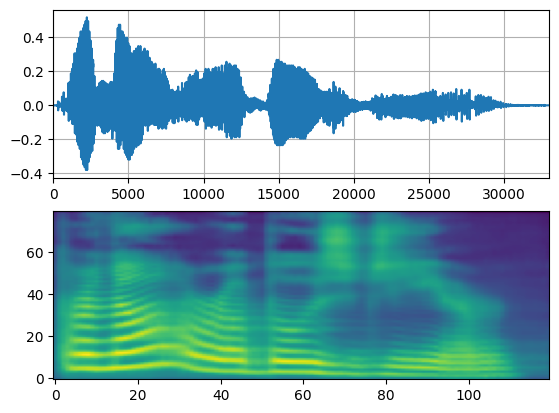

In [36]:
plot(new_waveforms, new_spec, vocoder.sample_rate)

In [3]:
import playsound
def execute_audio(wav_file: str):
    playsound.playsound(wav_file, block=False)

execute_audio("output.wav")